# ===============================================================
# 📜 Notebook Summary - cse521p-dino-yolov8
# ===============================================================
This notebook implements a **DINOv2-style Self-Supervised Learning (SSL)**
pretraining on the **YOLOv10 backbone** (conv net), followed by fine-tuning
 a YOLOv10 detector on your dataset. Finally, it visualizes learned features
via 2D **PCA** with k-means coloring.

# 🔹 What's inside:
   1) COCO → YOLO conversion (images/labels + data.yaml).
   2) SSL pretraining (DINOv2-style):
       - Student/Teacher (EMA) with cosine momentum schedule
       - Multi-crop views: 2 global + 8 local
       - Temperature schedule for teacher + probability centering
       - Cross-entropy between teacher probs (global) and student logits (all views)
   3) Save ONLY the SSL-pretrained YOLOv10 backbone weights.
   4) Fine-tune YOLOv10 detector initialized from those weights.
   5) Evaluate (mP, mR, mAP@0.50, mAP@0.50–0.95).
   6) PCA of backbone features (unsupervised clusters).

# ⚠️ Note:
   - This is a **DINOv2-style adaptation** to a convolutional backbone to keep
     weights compatible with YOLOv10 detection; official DINOv2 targets ViT backbones.
   - For better transfer: increase SSL_EPOCHS to 50–100; include more (even unlabeled) images.
# ===============================================================

# ===============================================================
# 0) Setup
# ===============================================================

In [1]:
!pip -q install ultralytics timm tqdm pillow 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.9 MB/s eta 0:00:00


In [2]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# ===============================================================
# 1) Paths
# ===============================================================

In [3]:
model_name = "8s"
model = "8"

In [4]:
BASE  = Path("/kaggle/input/annotated-rice-panicle-image-from-bangladesh")
WORK  = Path(f"/kaggle/working/rice_ssl_yolov{model}_dinov2")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_rice.yaml"
SSL_W = WORK / "backbone_ssl_v10_dinov2.pt"   # <-- conv backbone weights only
WORK.mkdir(parents=True, exist_ok=True)

# ===============================================================
# 2) COCO -> YOLO conversion (once)
# ===============================================================

In [5]:

def coco2yolo(b,w,h): x,y,bw,bh=b; return (x+bw/2)/w,(y+bh/2)/h,bw/w,bh/h

def convert(split,img_dir,ann_json):
    out_im,out_lb=SPLIT/split/"images",SPLIT/split/"labels"
    out_im.mkdir(parents=True,exist_ok=True)
    out_lb.mkdir(parents=True,exist_ok=True)
    coco=json.load(open(ann_json))
    id2={im["id"]:{k:im[k] for k in ("id","file_name","width","height")} for im in coco["images"]}
    for ann in coco["annotations"]:
        im=id2[ann["image_id"]]; yb=coco2yolo(ann["bbox"],im["width"],im["height"])
        with open(out_lb/f"{Path(im['file_name']).stem}.txt","a") as f:
            f.write(f"{ann['category_id']-1} "+" ".join(f"{v:.6f}" for v in yb)+"\n")
    for im in coco["images"]:
        src = Path(img_dir)/im["file_name"]
        if src.exists():
            shutil.copy(src, out_im/im["file_name"])

if not DATA.exists():
    print("➤ Converting COCO → YOLO …")
    convert("train", BASE/"train",  BASE/"train/_annotations.coco.json")
    convert("valid", BASE/"valid",  BASE/"valid/_annotations.coco.json")
    convert("test",  BASE/"valid",  BASE/"valid/_annotations.coco.json")  # simple test = valid
    names=[c["name"] for c in sorted(json.load(open(BASE/'train/_annotations.coco.json'))["categories"],
                                     key=lambda x:x["id"])]
    DATA.write_text(yaml.dump({"path":str(SPLIT),
                               "train":"train/images",
                               "val":"valid/images",
                               "test":"test/images",
                               "nc":len(names),"names":names}))
    print("✓ YOLO split ready.")
else:
    print("YOLO split already exists")

➤ Converting COCO → YOLO …
✓ YOLO split ready.


# ===============================================================
# 3) Multi-crop dataset (DINOv2-style: 2 global + 8 local)
# ===============================================================

In [6]:

class MultiCropDINO(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        crops=[self.g1(img), self.g2(img)]
        crops.extend([self.local(img) for _ in range(self.n_local)])
        return crops

# ===============================================================
# 4) Build YOLOv10s model and grab backbone (no fallback)
#    Robust encoder that handles different backbone return types/shapes
# ===============================================================

In [7]:
detector = YOLO(f"yolov{model_name}.yaml")   # requires Ultralytics with YOLOv10 assets
model = detector.model

student_bb = model.model[0].to(device)
teacher_bb = YOLO(f"yolov{model_name}.yaml").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters(): p.requires_grad=False

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        # some modules could return nested structures
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        # shape adapt: [B,C,H,W] → GAP; [B,C,T] → mean over T; [B,C] → as-is; else flatten
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

with torch.no_grad():
    dmy = torch.zeros(1,3,224,224,device=device)
    feat_dim = student_enc(dmy).shape[1]
print("Backbone feature dim:", feat_dim)

Backbone feature dim: 32


# ===============================================================
# 5) DINOv2-style projector heads + loss
# ===============================================================

In [8]:
OUT_DIM = 256

def projector(in_dim, hid=2048, out=OUT_DIM):
    return nn.Sequential(
        nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): p.requires_grad=False

class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global=n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1,out_dim))
    def teacher_T(self, epoch):
        if epoch < self.warmup_frac*self.T:
            a=epoch/(self.warmup_frac*self.T)
            return self.t_warm + (self.t_final-self.t_warm)*a
        return self.t_final
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s/self.student_temp for s in s_out]
        t_probs  = [F.softmax((t - self.center)/Tt, dim=-1).detach() for t in t_out]
        loss=0; cnt=0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v==iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt,1)
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center*self.cm + (1-self.cm)*batch_center
        return loss


# ===============================================================
# 6) DINOv2-style SSL pretraining
# Students must train for at least 50 epochs.

# To retrain with a higher epoch count:
# 1) Set `SSL_EPOCHS = 50` (or your desired value).
# 2) In Kaggle, select “Factory Reset” to clear state.
# 3) Click “Run All” to execute the notebook from a clean start.
# ===============================================================

In [9]:

EPOCHS     = 50       # increase to 50–100 for stronger transfer
BATCH      = 16
ACCUM      = 2
LR         = 5e-4
WD         = 0.05
EMA0       = 0.996
N_LOCAL    = 8
NUM_WORKERS= 0

if SSL_W.exists():
    print("✓ SSL backbone cache found – skipping DINOv2-style pretrain")
else:
    print(f"\n DINOv2-style pretraining on YOLOv{model_name} backbone …")
    ds = MultiCropDINO([SPLIT/"train/images", SPLIT/"valid/images", SPLIT/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0

    student_enc.train(); student_head.train()
    for ep in range(EPOCHS):
        ep_loss=0.0; accum=0
        opt.zero_grad(set_to_none=True)
        for views in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False):
            views = [v.to(device) for v in views]  # [g1, g2, l1..lN]
            with autocast_ctx():
                s_feats = [student_enc(v) for v in views]
                s_outs  = [student_head(z) for z in s_feats]              # all crops
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in views[:2]]         # globals only
                    t_outs  = [teacher_head(z) for z in t_feats]
                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            scaler.scale(loss).backward()
            accum += 1
            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (cosine momentum) for teacher backbone + head
                m = 1 - (1-EMA0) * (math.cos(math.pi*gstep/total_steps)+1)/2
                with torch.no_grad():
                    for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                gstep += 1

            ep_loss += loss.item() * ACCUM

        lr_sched.step()
        print(f"SSL Epoch {ep+1:02d}: loss={ep_loss/steps_per_epoch:.4f}")

    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    torch.save(student_bb.state_dict(), SSL_W)
    del ds, dl
    gc.collect()
    print(f"✓ Saved SSL YOLOv{model_name} backbone →", SSL_W)



 DINOv2-style pretraining on YOLOv8s backbone …


/tmp/ipykernel_19/3504635033.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


SSL Ep 1/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 01: loss=6.3534


SSL Ep 2/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 02: loss=4.5461


SSL Ep 3/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 03: loss=4.4021


SSL Ep 4/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 04: loss=5.0704


SSL Ep 5/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 05: loss=5.9892


SSL Ep 6/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 06: loss=7.5175


SSL Ep 7/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 07: loss=8.2955


SSL Ep 8/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 08: loss=8.0409


SSL Ep 9/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 09: loss=6.9945


SSL Ep 10/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 10: loss=6.0546


SSL Ep 11/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 11: loss=6.0615


SSL Ep 12/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 12: loss=6.1187


SSL Ep 13/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 13: loss=6.0109


SSL Ep 14/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 14: loss=6.0221


SSL Ep 15/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 15: loss=6.1136


SSL Ep 16/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 16: loss=5.8103


SSL Ep 17/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 17: loss=5.6699


SSL Ep 18/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 18: loss=5.6413


SSL Ep 19/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 19: loss=5.6066


SSL Ep 20/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 20: loss=5.7375


SSL Ep 21/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 21: loss=5.6058


SSL Ep 22/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 22: loss=5.5692


SSL Ep 23/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 23: loss=5.5559


SSL Ep 24/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 24: loss=5.5512


SSL Ep 25/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 25: loss=5.5482


SSL Ep 26/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 26: loss=5.5482


SSL Ep 27/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 27: loss=5.5452


SSL Ep 28/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 28: loss=5.5435


SSL Ep 29/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 29: loss=5.5408


SSL Ep 30/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 30: loss=5.5394


SSL Ep 31/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 31: loss=5.5367


SSL Ep 32/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 32: loss=5.5359


SSL Ep 33/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 33: loss=5.5370


SSL Ep 34/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 34: loss=5.5358


SSL Ep 35/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 35: loss=5.5347


SSL Ep 36/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 36: loss=5.5328


SSL Ep 37/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 37: loss=5.5341


SSL Ep 38/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 38: loss=5.5339


SSL Ep 39/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 39: loss=5.5337


SSL Ep 40/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 40: loss=5.5327


SSL Ep 41/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 41: loss=5.5337


SSL Ep 42/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 42: loss=5.5341


SSL Ep 43/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 43: loss=5.5341


SSL Ep 44/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 44: loss=5.5345


SSL Ep 45/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 45: loss=5.5338


SSL Ep 46/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 46: loss=5.5336


SSL Ep 47/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 47: loss=5.5344


SSL Ep 48/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 48: loss=5.5332


SSL Ep 49/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 49: loss=5.5344


SSL Ep 50/50:   0%|          | 0/137 [00:00<?, ?it/s]

SSL Epoch 50: loss=5.5351
✓ Saved SSL YOLOv8s backbone → /kaggle/working/rice_ssl_yolov8_dinov2/backbone_ssl_v10_dinov2.pt


# ===============================================================
# 7) Detector fine-tuning (YOLOv10s, init with SSL backbone)
# ===============================================================

In [10]:

det = YOLO(f"yolov{model_name}.yaml")  # fresh model
missing, unexpected = det.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
print("Loaded backbone with missing:", len(missing), " unexpected:", len(unexpected))

det.train(data=str(DATA),
          epochs=5,
          imgsz=640,
          batch=8,
          project=str(WORK),
          name=f"ssl_yolov{model_name}_dinov2",
          device=0 if device=="cuda" else "cpu")

Loaded backbone with missing: 0  unexpected: 0
Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/rice_ssl_yolov8_dinov2/data_rice.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=ssl_yolov8s_dinov2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2911.4±799.0 MB/s, size: 139.0 KB)


train: Scanning /kaggle/working/rice_ssl_yolov8_dinov2/yolo_split/train/labels... 1754 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1754/1754 [00:01<00:00, 1376.84it/s]

train: New cache created: /kaggle/working/rice_ssl_yolov8_dinov2/yolo_split/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1380.3±1090.0 MB/s, size: 147.5 KB)


val: Scanning /kaggle/working/rice_ssl_yolov8_dinov2/yolo_split/valid/labels... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<00:00, 843.74it/s] 

val: New cache created: /kaggle/working/rice_ssl_yolov8_dinov2/yolo_split/valid/labels.cache


Plotting labels to /kaggle/working/rice_ssl_yolov8_dinov2/ssl_yolov8s_dinov2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/rice_ssl_yolov8_dinov2/ssl_yolov8s_dinov2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.43G      4.026       2.72      3.212         66        640: 100%|██████████| 220/220 [00:34<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.08it/s]


                   all        219       3962      0.229      0.307      0.182     0.0554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.46G      2.679      1.919      2.087         57        640: 100%|██████████| 220/220 [00:33<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  9.07it/s]

                   all        219       3962      0.381      0.396      0.346      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.51G      2.351      1.721       1.84         47        640: 100%|██████████| 220/220 [00:32<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  9.32it/s]

                   all        219       3962      0.325       0.44      0.309       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.54G      2.188      1.616      1.718         79        640: 100%|██████████| 220/220 [00:32<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  9.42it/s]


                   all        219       3962      0.456        0.5      0.438      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.58G      2.075      1.537      1.634         61        640: 100%|██████████| 220/220 [00:32<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  9.38it/s]

                   all        219       3962       0.52      0.534      0.517      0.246



5 epochs completed in 0.049 hours.
Optimizer stripped from /kaggle/working/rice_ssl_yolov8_dinov2/ssl_yolov8s_dinov2/weights/last.pt, 22.5MB
Optimizer stripped from /kaggle/working/rice_ssl_yolov8_dinov2/ssl_yolov8s_dinov2/weights/best.pt, 22.5MB

Validating /kaggle/working/rice_ssl_yolov8_dinov2/ssl_yolov8s_dinov2/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        219       3962       0.52      0.534      0.518      0.246
          Rice-Panicle        219       3962       0.52      0.534      0.518      0.246
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 11.3ms postprocess per image
Results saved to /kaggle/working/rice_ssl_yolov8_dinov2/ssl_yolov8s_dinov2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x790d55b67190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# ===============================================================
# 8) Evaluate and visualize one image
# ===============================================================

Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2819.3±590.0 MB/s, size: 143.8 KB)


val: Scanning /kaggle/working/rice_ssl_yolov8_dinov2/yolo_split/valid/labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:03<00:00, 17.90it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        219       3962      0.522      0.532      0.518      0.246
          Rice-Panicle        219       3962      0.522      0.532      0.518      0.246
Speed: 0.3ms preprocess, 8.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val

Validation metrics
 Precision (mP) : 0.5215
 Recall    (mR) : 0.5321
 mAP@0.50      : 0.5178
 mAP@0.50-0.95 : 0.2457


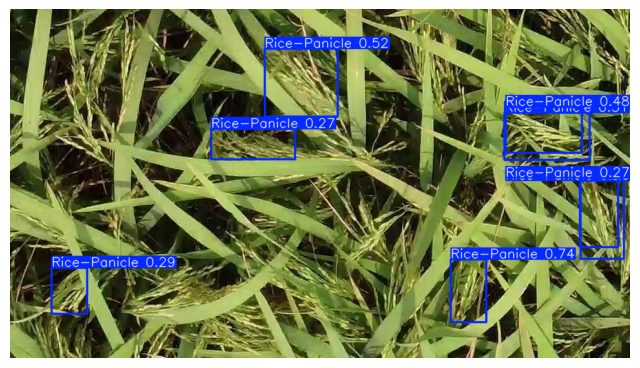

In [11]:
best_pt = WORK / f"ssl_yolov{model_name}_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

results = model_det.val(data=str(DATA),
                        imgsz=640,
                        batch=4,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")

# visualize a random test image
test_imgs = list((SPLIT/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()
else:
    print("No test images found for visualization.")

# ===============================================================
# 9) PCA of SSL-pretrained YOLOv10 backbone features (robust encoder)
# ===============================================================

PCA Feature matrix: (1000, 32)


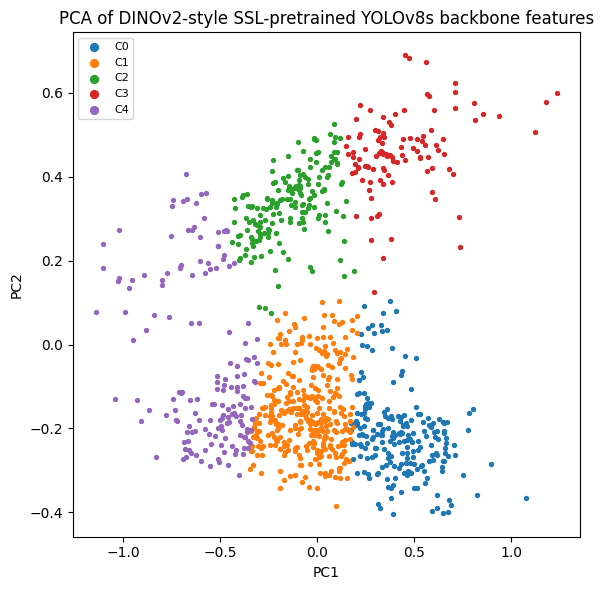

In [12]:
det_pca = YOLO(f"yolov{model_name}.yaml")
det_pca.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
bb = det_pca.model.model[0].to(device).eval()

class BBEnc(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

enc_pca = BBEnc(bb).to(device)
tfm_pca = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# sample images for PCA
IMG_DIRS = [SPLIT/"train/images", SPLIT/"valid/images"]
files=[]
for d in IMG_DIRS:
    if d.exists(): files += list(d.glob("*.*"))
random.shuffle(files)
files = files[:1000] if len(files)>1000 else files

feats=[]
with torch.no_grad():
    for p in files:
        try:
            img = Image.open(p).convert("RGB")
        except:
            continue
        x = tfm_pca(img).unsqueeze(0).to(device)
        z = enc_pca(x)
        feats.append(z.squeeze(0).cpu().numpy())
feats = np.stack(feats, axis=0)
print("PCA Feature matrix:", feats.shape)

pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(feats)

k = 5
lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(feats)

plt.figure(figsize=(6,6))
for i in range(k):
    m = (lab==i)
    plt.scatter(xy[m,0], xy[m,1], s=8, label=f"C{i}")
plt.title(f"PCA of DINOv2-style SSL-pretrained YOLOv{model_name} backbone features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()
